In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dict_img_position = {
    'main':[0, 200],
    'ht':[200, 650],
    'loss':[650, 920],
    'overall_results':[930, 1150]}

In [33]:
from modules.summarizing_utils.common_filter_results_methods import get_img_list
from modules.summarizing_utils.filter_results_utils import get_available_attr
from modules.summarizing_utils.filter_results_utils import filter_results

from modules.summarizing_utils.save_imgs import save_imgs2pdf
from modules.summarizing_utils.sorting_methods import sort_by_attr_values

from modules.summarizing_utils.heatmaps import get_override_dict_list
from modules.summarizing_utils.heatmaps import quantitative_results_HEATMAPS

## Obtain attribute dictionary

In [34]:
import glob

In [35]:
modes = ['L1Loss', 'MSE', 'SSIM', 'SSIM11', 'SSIM5', 'last_converged']
interested_modes = ['L1Loss', 'MSE', 'SSIM5', 'SSIM11']

exp_set_dir = 'figs/mnistv19'

for dir_ in glob.glob(f'{exp_set_dir}/*'):
    if dir_.split('/')[-1]=='heatmaps' or dir_.split('/')[-1]=='_results_summaries':continue
    for img_dir in glob.glob(f'{dir_}/*.jpg'):
        if '150_' in img_dir:break
    else:
        print(f'Incompleted exp : {dir_}')
else:
    print('All exps are completed')
print('\n\n')

mode= interested_modes[0]
img_list = get_img_list(img_dir = exp_set_dir, mode=mode)
print('img_list length : ', len(img_list))
dict_ = get_available_attr(img_list)
interested_imgs = filter_results(img_list, dict_)
print(f'available keys : {list(dict_img_position.keys())}')

dict_

Incompleted exp : figs/mnistv19/errors.txt
All exps are completed



1/50 : figs/mnistv19/num_samples_train(3000)@upsample_net_init_method(xavier_normal)@upsample_net(bicubic_interp)@lr_H(0.0)/150_L1Loss(0.0850306)_MSE(0.0401578)_SSIM11(0.6272145)_SSIM5(0.6438994).jpg
len img dirs : 50
img_list length :  50
50 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']


{'num_samples_train': ['3000', '4500', '600', '6000', '7500'],
 'upsample_net_init_method': ['xavier_normal'],
 'upsample_net': ['bicubic_interp',
  'custom_v2',
  'custom_v3',
  'custom_v4',
  'learnable_transpose_conv'],
 'lr_H': ['0.0', '1.0']}

## Save qualitative results and Quantitative results (HEATMAPS) to PDF

In [36]:
def save_HEATMAPS(mode, img_list, exp_set_dir= None): ## CHANGE THIS 
    print(mode)    
    plot_vars_dict = {
         'T': ['1', '2', '4', '8', '16', '32'],
         'lambda_scale_factor': ['1', '2', '3', '4']}

    all_overrides_dict = {'img_size': ['128', '64'],
                 'rotation_lambda': ['10.0', '100.0', '1000.0', '10000.0'],
                 'ht_init_method': ['uniformones_FourierBased', 'randn_FourierBased', 'hadamard_FourierBased']}

    overrides_dict_list = get_override_dict_list(all_overrides_dict) ## obtain all combinations of override dicts
    quantitative_results_HEATMAPS(img_list, plot_vars_dict, overrides_dict_list, mode, save_dir = exp_set_dir)

In [37]:
def save_HEATMAPS(mode, img_list, exp_set_dir= None): ## CHANGE THIS 
    print(mode)    
    plot_vars_dict = {
         'num_samples_train': ['600', '3000', '4500', '6000', '7500'],
         'upsample_net': ['bicubic_interp', 'custom_v2', 'custom_v3', 'custom_v4', 'learnable_transpose_conv']}

    all_overrides_dict = {}

    overrides_dict_list = get_override_dict_list(all_overrides_dict) ## obtain all combinations of override dicts
    quantitative_results_HEATMAPS(img_list, plot_vars_dict, overrides_dict_list, mode, save_dir = exp_set_dir)

1/50 : figs/mnistv19/num_samples_train(3000)@upsample_net_init_method(xavier_normal)@upsample_net(bicubic_interp)@lr_H(0.0)/150_L1Loss(0.0850306)_MSE(0.0401578)_SSIM11(0.6272145)_SSIM5(0.6438994).jpg
len img dirs : 50
img_list length :  50
50 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']
qualitative results saved : figs/mnistv19/_results_summaries/results_MSE.pdf
MSE
attr_dict_highlrH : {'num_samples_train': ['600', '3000', '4500', '6000', '7500'], 'upsample_net': ['bicubic_interp', 'custom_v2', 'custom_v3', 'custom_v4', 'learnable_transpose_conv'], 'lr_H': ['1.0']}
attr_dict_lowlrH : {'num_samples_train': ['600', '3000', '4500', '6000', '7500'], 'upsample_net': ['bicubic_interp', 'custom_v2', 'custom_v3', 'custom_v4', 'learnable_transpose_conv'], 'lr_H': ['0.0']}
ploting heatmaps ... 
override dict : {}
25 images are found !!!
25 images are found !!!


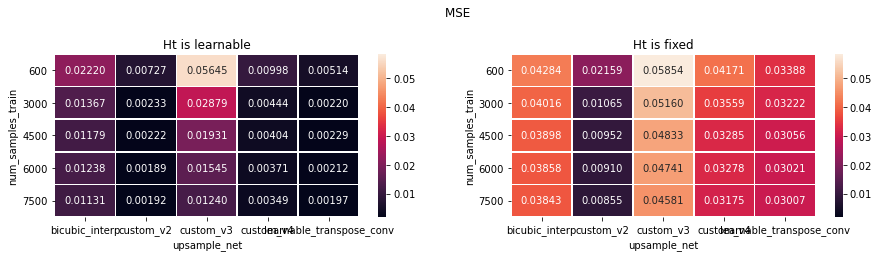

ploting heatmaps finished !!!
quantitative results saved : figs/mnistv19/heatmaps/summary.pdf


In [38]:
import shutil, os

try:shutil.rmtree(f'{exp_set_dir}/_results_summaries')
except:pass

try:shutil.rmtree(f'{exp_set_dir}/heatmaps')
except:pass

os.mkdir(f'{exp_set_dir}/_results_summaries')

for mode in ['MSE']: #interested_modes:
    img_list = get_img_list(img_dir = exp_set_dir, mode=mode)
    print('img_list length : ', len(img_list))

    dict_ = get_available_attr(img_list)
    interested_imgs = filter_results(img_list, dict_)
    print(f'available keys : {list(dict_img_position.keys())}')

    #show_results('main', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('loss', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('ht', dict_img_position, interested_imgs,  sort_by_attr_values)
    #show_results('overall_results', dict_img_position, interested_imgs,  sort_by_attr_values)

    img_pdf_filename = f'{exp_set_dir}/_results_summaries/results_{mode}.pdf'
    save_imgs2pdf(interested_imgs, sorting_function= sort_by_attr_values, pdf_filename=img_pdf_filename, attr_dict= dict_)
    print(f'qualitative results saved : {img_pdf_filename}')
    
    ## ABOVE attr_dict_highlrH, attr_dict_lowlrH -> ONLY CONTAIN KEYS: lr_H, interested_key1, interested_key2 || Other keys -> goes into override dicts !!!

    save_HEATMAPS(mode, img_list, exp_set_dir)

## Convert HEATMAP values to MATLAB format

In [1]:
#exp_set_dir = 'figs/mnistv13'

print('exp_set_dir :',exp_set_dir) 
heatmap_zipped_dir = './heatmaps_mat_files.zip' #f'{exp_set_dir}/heatmaps/heatmaps_mat_files.zip'

exp_set_dir : figs/mnistv13


In [ ]:
!rm -rf ./test
!rm $heatmap_zipped_dir

In [ ]:
#%%capture
from modules.summarizing_utils.numpy2mat import zip_heatmap_vals_matlab
zip_heatmap_vals_matlab(exp_set_dir=exp_set_dir, target_dir = heatmap_zipped_dir)

In [4]:
%%capture
!mkdir ./test
!unzip $heatmap_zipped_dir -d ./test

In [ ]:
!ls ./test

In [6]:
import os 
len(os.listdir('./test'))

192

In [7]:
!rm -rf ./test
!rm $heatmap_zipped_dir